In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torch.nn.functional import one_hot

from data_loaders.pulja_data_loader_02 import PuljaDataLoader
from models._dkt import UserModel
from models.utils_02 import collate_fn

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    from torch import FloatTensor, LongTensor

In [2]:
ckpt_path = "ckpts"
if not os.path.isdir(ckpt_path):
    os.mkdir(ckpt_path)

batch_size = 256
num_epochs = 100
train_ratio = 0.9

seq_len = 100

dim_v = 20

dataset = PuljaDataLoader(seq_len)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model = UserModel(dataset.num_c1, dataset.num_c2, dataset.num_c3, dataset.num_d, dim_v).to(device)

train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size]
)

if os.path.exists(os.path.join(dataset.dataset_dir, "indices.pkl")):
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "rb") as f:
        indices = pickle.load(f)
    train_dataset.indices = indices[0]
    test_dataset.indices = indices[1]
else:
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "wb") as f:
        pickle.dump((train_dataset.indices, test_dataset.indices), f)


In [3]:
model.load_state_dict(
    torch.load(
        os.path.join(
            os.path.join(
                ckpt_path, "_dkt"
            ),
            "model_max.ckpt"
        ),
        map_location=device
    )
)
model.eval()

UserModel(
  (X): Embedding(546, 20)
  (gru): GRU(40, 20, batch_first=True)
  (out_layer): Linear(in_features=20, out_features=546, bias=True)
  (dropout_layer): Dropout(p=0.5, inplace=False)
)

In [4]:
aucs_list = []
max_aucs = []
fin_aucs = []

dir_list = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10"]

for i in dir_list:
    with open(
        os.path.join(
            os.path.join(
                ckpt_path,
                os.path.join("_dkt", i)
            ),
            "aucs.pkl"
        ),
        "rb"
    ) as f:
        aucs = pickle.load(f)
    
    max_auc = np.max(aucs)
    fin_auc = aucs[-1]

    aucs_list.append(aucs)
    max_aucs.append(max_auc)
    fin_aucs.append(fin_auc)

In [5]:
print("max_aucs: {}".format(max_aucs))
print("max_auc_mean: {}, max_auc_std: {}".format(np.mean(max_aucs), np.std(max_aucs)))
print("max_auc_dir: {}".format(dir_list[np.argmax(max_aucs)]))

max_aucs: [0.7910433707315387, 0.7890042117720447, 0.788427994006247, 0.7860225814693496, 0.7907143619675885, 0.7891723975616562, 0.7892461899522671, 0.7896710330702273, 0.7892999639141483, 0.7884958490424544]
max_auc_mean: 0.7891097953487523, max_auc_std: 0.0013065543520997139
max_auc_dir: 01


In [6]:
print("max_fin_aucs: {}".format(fin_aucs))
print("max_fin_auc_mean: {}, max_auc_std: {}".format(np.mean(fin_aucs), np.std(fin_aucs)))
print("max_fin_auc_dir: {}".format(dir_list[np.argmax(fin_aucs)]))

max_fin_aucs: [0.7699476003683268, 0.7654805592702756, 0.7595107353472307, 0.7596946228982006, 0.7659987235927563, 0.7608821092730413, 0.761403220580928, 0.766760291556329, 0.758230494853389, 0.7625682776388728]
max_fin_auc_mean: 0.7630476635379349, max_auc_std: 0.003613889284476114
max_fin_auc_dir: 01


In [7]:
test_dataset[3]

(array([29, 29, 29, ..., 76, 76, 76]),
 array([2, 2, 3, ..., 4, 4, 4]),
 array([1, 1, 0, ..., 0, 0, 0]))

In [8]:
# 3, 6
c3_seq, d_seq, r_seq = test_dataset[3]

view_from = 0
view_to = 200

seq_len = view_to - view_from

c3_seq = [c3_seq[view_from:view_to]]
d_seq = [d_seq[view_from:view_to]]
r_seq = [r_seq[view_from:view_to]]

# r_seq = np.zeros_like(r_seq)
# r_seq = np.ones_like(r_seq)

# d_seq = np.ones_like(d_seq) * 6

# c_seq = np.array([[0] * 100])
# d_seq = np.array([[6] * 30 + [3] * 30 + [0] * 40])
# r_seq = np.ones_like(r_seq)

###########################################
alpha_seq, h_seq = model(
    LongTensor(c3_seq),
    LongTensor(d_seq),
    LongTensor(r_seq),
)
alpha_seq = alpha_seq.squeeze()

C_seq = alpha_seq.mean(-1)
alpha_seq = C_seq.mean(-1)
###########################################

sigmoid_alpha_seq = torch.sigmoid(alpha_seq).detach().cpu().numpy()

r_seq_ma = np.cumsum(r_seq[0]) / np.arange(1, r_seq[0].shape[0] + 1)

# CQ3_seq = torch.sigmoid(alpha_seq.unsqueeze(-1)).detach().cpu().numpy()
CQ3_seq = torch.sigmoid(C_seq).squeeze().detach().cpu().numpy()

# alpha_seq = alpha_seq.detach().cpu().numpy()

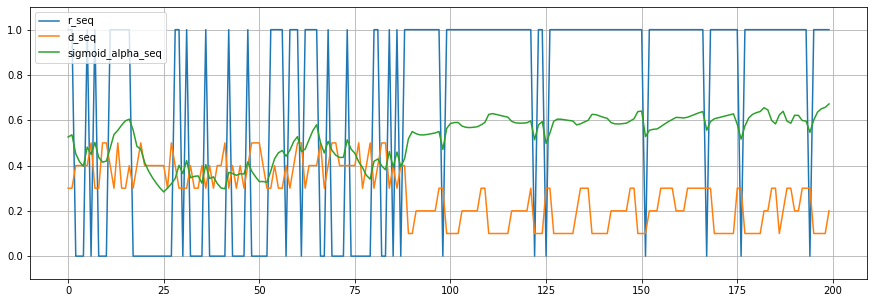

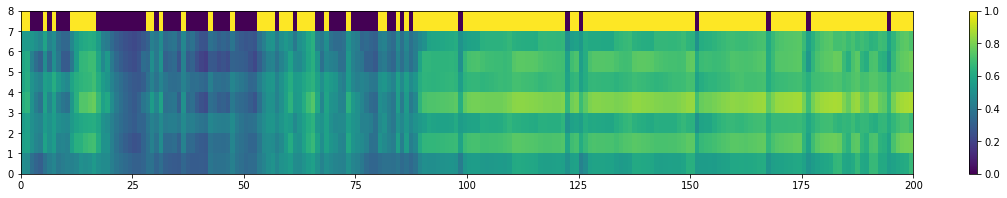

In [13]:
plt.figure(figsize=[15, 5], facecolor="white")
plt.plot(r_seq[0], label="r_seq")
plt.plot((d_seq[0] + 1) / 10, label="d_seq")
plt.plot(sigmoid_alpha_seq, label="sigmoid_alpha_seq")
plt.grid()
plt.ylim(-0.1, 1.1)
plt.legend()
plt.show()

plt.figure(figsize=[20, len(np.unique(c3_seq)) // 3 + 1], facecolor="white")
temp = np.concatenate([CQ3_seq[:, np.unique(c3_seq)].T, r_seq], axis=0)
plt.pcolormesh(temp)
plt.colorbar()
plt.show()

In [10]:
CQ3_seq[0][np.unique(c3_seq)]

array([0.4878711 , 0.56075   , 0.5489178 , 0.62641627, 0.58871424,
       0.58801955, 0.5414198 ], dtype=float32)

In [11]:
CQ3_seq[-1][np.unique(c3_seq)]

array([0.66953146, 0.7899077 , 0.6792883 , 0.87521607, 0.74172795,
       0.77873814, 0.7156923 ], dtype=float32)

In [12]:
np.unique(c3_seq), c3_seq

(array([17, 26, 29, 42, 50, 73, 75]),
 [array([29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 50, 50, 50, 50, 50,
         50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 73, 73, 73, 73, 73, 73,
         73, 73, 73, 73, 73, 73, 73, 73, 75, 75, 75, 75, 75, 75, 75, 75, 75,
         75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75,
         75, 75, 75, 75, 75, 75, 75, 75, 75, 17, 17, 17, 17, 17, 17, 17, 17,
         17, 17, 17, 17, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
         26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
         26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
         26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
         26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 42,
         42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
         42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42])])